In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import glob
import sys
import os
import pickle
import tqdm

import shield_optimization as so

In module 'Darwin':
/Applications/Xcode.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX.sdk/usr/include/libkern/arm/OSByteOrder.h:14:1: error: '_OSSwapInt16' has different definitions in different modules; definition in module 'Darwin.libkern.OSByteOrder' first difference is return type is 'uint16_t' (aka 'unsigned short')
uint16_t
^~~~~~~~
/Applications/Xcode.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX.sdk/usr/include/libkern/arm/_OSByteOrder.h:49:1: note: but in 'DarwinFoundation.OSByteOrder' found different return type '__uint16_t' (aka 'unsigned short')
__uint16_t
^~~~~~~~~~
In module 'Darwin':
/Applications/Xcode.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX.sdk/usr/include/libkern/arm/OSByteOrder.h:24:1: error: '_OSSwapInt32' has different definitions in different modules; definition in module 'Darwin.libkern.OSByteOrder' first difference is return type is 'uint32_t' (aka 'unsigned int')
uint32_t
^~~~~~~~


Welcome to JupyROOT 6.30/04


In [2]:
plt.style.use('tableau-colorblind10')
plt.style.use('../figures/style.mplstyle')

In [3]:
detectors = ['lowmass', 'highmass1', 'highmass2']

leadrates = so.BackgroundRates(match = 'Lead*_PE1.000000_*_t*.root', Ndefault = 1e8, folder = '../build/rate_data/', verbose = 3, part = 5)
leadrates.pre_analyze()

collecting 1696 files


In [4]:

# collect rate data
rates = []
drates = []
lead = []
poly = [] 

for l, p in leadrates.rates:
    lead.append(l)
    poly.append(p)
    rates.append(leadrates.rates[(l,p)][:,0])
    drates.append(leadrates.drates[(l,p)][:,0])

rates = np.array(rates)
drates = np.array(drates)
lead = np.array(lead)
poly = np.array(poly)


plt.figure()
#plt.errorbar(poly, lm_capture/1e3, yerr = lm_capture_err/1e3, linestyle = '', marker = '_', capsize = 2, label = 'lowmass capturees')
plt.errorbar(lead, rates[:,0]/1e3, yerr = drates[:,0]/1e3, linestyle = '', marker = '_', capsize = 2, label = 'highmass1 all background')
plt.errorbar(lead, rates[:,1]/1e3, yerr = drates[:,1]/1e3, linestyle = '', marker = '_', capsize = 2, label = 'highmass2 all background')
plt.grid()
#plt.semilogy()
plt.title(f'lead + 1 cm poly')
plt.xlabel('lead thickness [cm]')
plt.ylabel('rate [kHz]')
plt.legend()

AttributeError: 'BackgroundRates' object has no attribute 'rates'

In [ ]:
lead, poly, rate, drate = leadrates.get_capture_rate()

plt.errorbar(lead, rate, yerr = drate, linestyle = '', marker = '_', capsize = 2)
plt.grid()
plt.title(f'rate of nCapture vs lead thickness')
plt.xlabel('lead thickness [cm]')
plt.ylabel('capture rate [Hz]')

print(f'{lead[-1]} cm: captures {rate[-1]} Hz\n{rate[-1]*0.052/100} Hz signal rate ({rate[-1]*0.052/100*3600} per hour)')

In [ ]:
leadrates.rates_accessor['lowmass']['hadElastic']

In [ ]:
leadrates.rates[(20.,1.)][2,0], leadrates.drates[(20.,1.)][2,0]

In [ ]:
leadrates.totals[(20.,1.)]

In [ ]:
leadrates.rates[(20.,1.)][2,1], leadrates.drates[(20.,1.)][2,1] # Hz

In [6]:
def identify_deposit(PName):
    if PName in 'e- e+ gamma proton alpha deuteron triton':
        return 0
    elif PName in 'P31 ' or PName[:2] in 'Si Al Mg Ge Ga As Se Zn': 
        return 1
    else:
        raise Exception('unknown PName = ' + PName)


def collect_rates(rates, condition = ''):
    # collect count of events of each type and in each detector for events with "condition" == True
    XR = -1
    ER = 0
    NR = 1

    # separating by ER/NR (no energy cuts)
    counts = {meas: np.zeros((2,3)) for meas in rates.measurements_list}

    for i in tqdm.trange(rates.N):

        meas = rates.measurements[i]

        tfile = ROOT.TFile.Open(rates.glob_list[i], 'READ')
        tree = tfile.Get('tree')

        last_event = -1
        hits = np.zeros((2,3))
        energy = np.zeros((2,3)) # [ER/NR, detector]
        count_this = False
        evttype = XR

        for k in range(tree.GetEntries()):
            tree.GetEntry(k)
            EventNum = int(getattr(tree, 'EventNum'))
            TrkNum = int(getattr(tree, 'TrkNum'))
            Edep = float(getattr(tree, 'Edep'))
            VolName = getattr(tree, 'VolName')
            PName = getattr(tree, 'PName')
            ProcName = getattr(tree, 'ProcName')
            ParentVol = getattr(tree, 'ParentVol')
            IsCapture = getattr(tree, 'IsCapture')
            KE = float(getattr(tree, 'KE'))
            KE3 = float(getattr(tree, 'KE3'))
            DepProc = getattr(tree, 'DepProc')
            Time = float(getattr(tree, 'Time'))
            X = float(getattr(tree, 'X'))
            Y = float(getattr(tree, 'Y'))
            Z = float(getattr(tree, 'Z'))

            if abs(EventNum - last_event) > 1e-6: # new event

                # process previous event
                if condition != '':
                    exec(f"count_this = ({condition})")
                else:
                    count_this = True

                if count_this:
                    counts[meas] += hits

                last_event = EventNum
                energy = np.zeros((2,3))
                hits = np.zeros((2,3))

            # accumulate info from this event
            if Edep > 0:
                DT = identify_deposit(PName)
                for j, vol in enumerate(('highmass1', 'highmass2', 'lowmass')):
                    if VolName == vol:
                        energy[DT][j] += Edep
                        hits[DT][j] = 1
            
            # end of loop over tree

        # end of loop over files

    # end of function: return counts
    return counts



In [ ]:
#collected_rates = collect_rates(leadrates)

In [8]:
def yLind(Er):
    Er *= 1e3 # convert to keV from MeV
    Z = 28
    k = 0.15
    eps = 11.5*Er/np.cbrt(Z)**7
    g = 3*eps**0.15 + 0.7*eps**0.6 + eps
    Y = k*g/(1+k*g) # yield
    return Y 


def get_charge_histograms(rates, Ebins = None, Emin = 100e-6, Emax = 20, Nbins = 200):
    # collect histograms of charge energy in hm1 and hm2, as well as histograms of charge energy in hm1 and hm2 WITH COINCIDENCES WITH lowmass

    XR = -1
    ER = 0
    NR = 1

    if Ebins == None:
        Ebins = np.linspace(Emin, Emax, Nbins+1, endpoint = True) # bin edges (MeV)
    else:
        Emin = Ebins[0]
        Emax = Ebins[-1]
        Nbins = Ebins.size - 1

    hm = ('highmass1', 'highmass2')
    lm = 'lowmass'
    detectors = ('highmass1', 'highmass2', 'lowmass')

    ROOT.TH1.AddDirectory(False)


    events = {meas: {det: ROOT.TH1D(
            det + '_all',
            det + ' all',
            Nbins, Ebins
            ) for det in detectors} for meas in rates.measurements_list}
    
    coincs = {meas: {det: ROOT.TH1D(
            det + '_coinc',
            det + ' coincidence events',
            Nbins, Ebins
            ) for det in detectors} for meas in rates.measurements_list}
    
    for meas in rates.measurements_list:
        for det in hm:
            events[meas][det].Reset()
            coincs[meas][det].Reset()


    for i in tqdm.trange(rates.N):

        meas = rates.measurements[i]

        tfile = ROOT.TFile.Open(rates.glob_list[i], 'READ')
        tree = tfile.Get('tree')

        last_event = -1
        energy = {det: 0. for det in detectors}

        for k in range(tree.GetEntries()):
            tree.GetEntry(k)

            EventNum = int(getattr(tree, 'EventNum'))
            #TrkNum = int(getattr(tree, 'TrkNum'))
            Edep = float(getattr(tree, 'Edep'))
            VolName = getattr(tree, 'VolName')
            PName = getattr(tree, 'PName')
            #ProcName = getattr(tree, 'ProcName')
            ParentVol = getattr(tree, 'ParentVol')
            IsCapture = getattr(tree, 'IsCapture')
            #KE = float(getattr(tree, 'KE'))
            #KE3 = float(getattr(tree, 'KE3'))
            #DepProc = getattr(tree, 'DepProc')
            Time = float(getattr(tree, 'Time'))
            #X = float(getattr(tree, 'X'))
            #Y = float(getattr(tree, 'Y'))
            #Z = float(getattr(tree, 'Z'))

            if abs(EventNum - last_event) > 1e-6: # new event

                last_event = EventNum

                # process previous event
                for det in detectors:
                    if energy[det] > 0:
                        events[meas][det].Fill(energy[det])
                        if energy[lm] > 0:
                            coincs[meas][det].Fill(energy[det])

                energy = {det: 0. for det in detectors}


            # accumulate info from this event
            if (Edep > 0) and (Time < 1e9*360*24*365*100):
                DT = identify_deposit(PName)
                if DT == ER:
                    Eq = Edep
                elif DT == NR:
                    Eq = Edep*yLind(Edep)
                energy[VolName] += Eq
            
            # end of loop over tree

        tfile.Close()
        # end of loop over files

    # convert ROOT TH1D's into dataframes
    df = {}
    for meas in rates.measurements_list:
        data_dict = {'E': Ebins}
        for det in detectors:
            for dictionary in (events, coincs):
                hist = dictionary[meas][det]
                name = hist.GetName()
                cts = np.zeros(Nbins+1)

                for i in range(1, Nbins+1):
                    cts[i-1] = hist.GetBinContent(i)

                data_dict[name] = cts

        df[meas] = pd.DataFrame.from_dict(data_dict)

    # end of function: return dataframe
    return df



In [9]:
df = get_charge_histograms(leadrates)

100%|██████████| 1696/1696 [1:33:12<00:00,  3.30s/it]    


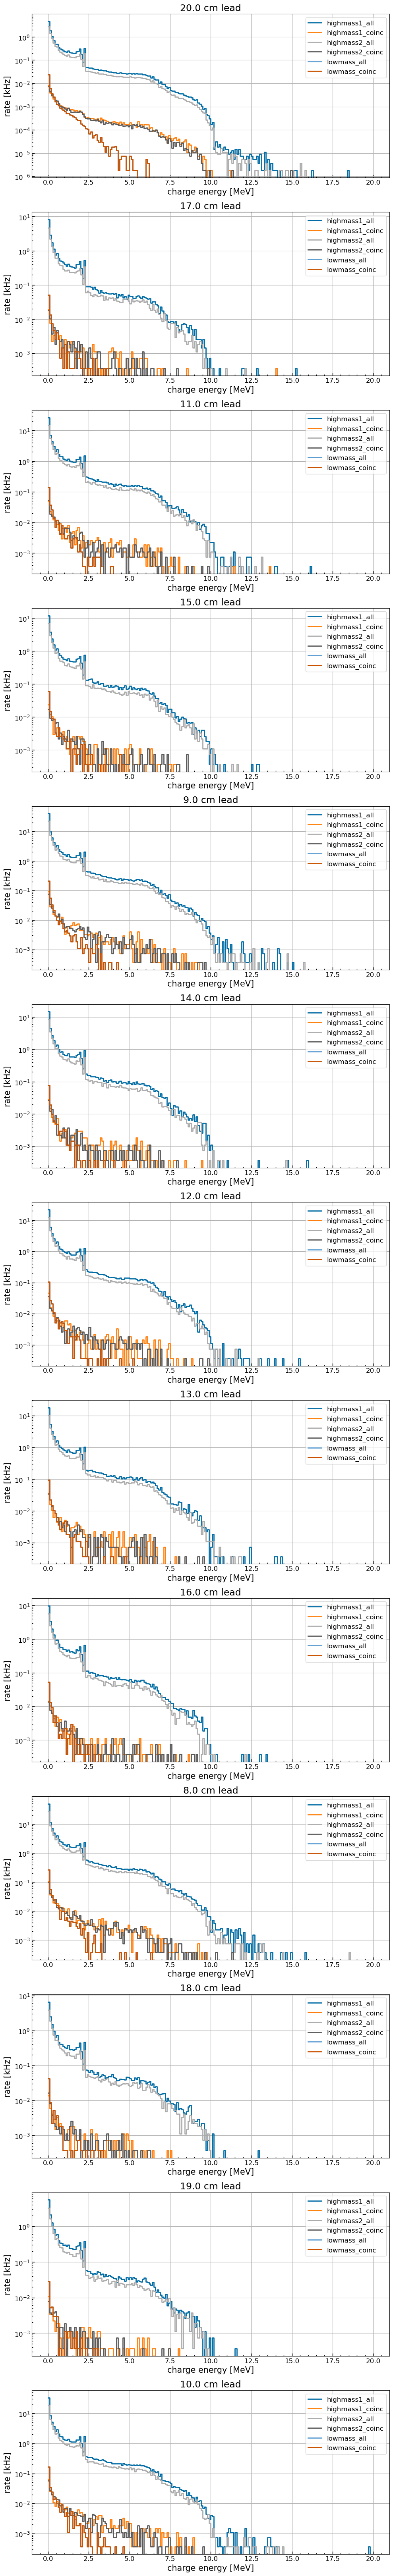

In [10]:
fig, axs = plt.subplots(nrows = len(df), ncols = 1, figsize = (10,len(df)*5))
for meas, ax in zip(df.keys(), axs):   

    
    ax.set_title(f'{meas[0]} cm lead')
    Ebins = df[meas]['E'].values

    for c in df[meas].columns[1:]:
        y = df[meas][c].values/1e3/leadrates.meas_exposures[meas]
        ax.step(Ebins, y, where = 'post', label = c)

    ax.semilogy()
    ax.grid()
    ax.legend()
    ax.set_xlabel('charge energy [MeV]')
    ax.set_ylabel('rate [kHz]')

fig.tight_layout()

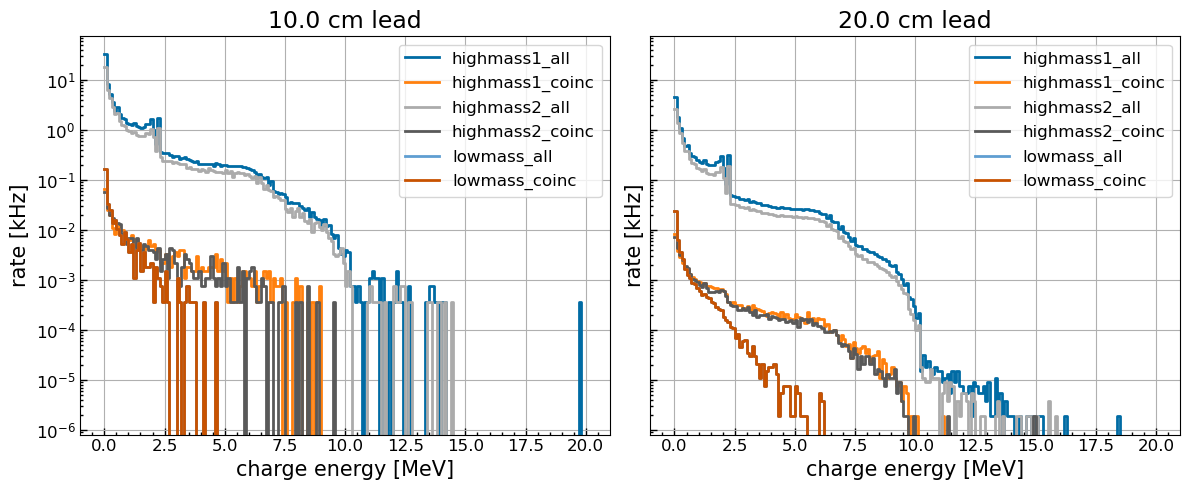

In [11]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5), sharey = True)
for meas, ax in zip(((10.,1.), (20.,1.)), axs):   

    
    ax.set_title(f'{meas[0]} cm lead')
    Ebins = df[meas]['E'].values

    for c in df[meas].columns[1:]:
        y = df[meas][c].values/1e3/leadrates.meas_exposures[meas]
        ax.step(Ebins, y, where = 'post', label = c)

    ax.semilogy()
    ax.grid()
    ax.legend()
    ax.set_xlabel('charge energy [MeV]')
    ax.set_ylabel('rate [kHz]')

fig.tight_layout()

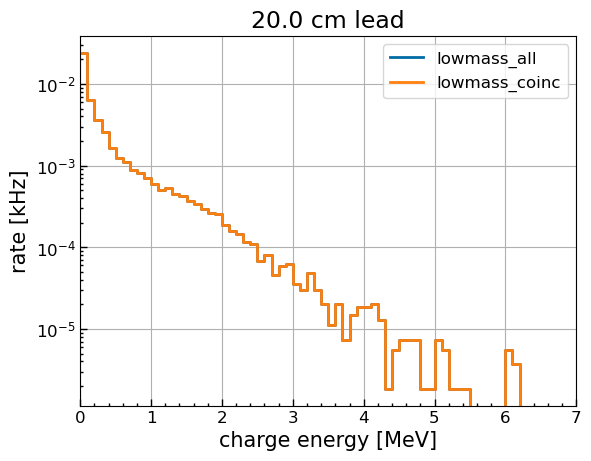

In [12]:
plt.figure()   
ax = plt.gca()
meas = (20.,1.)

ax.set_title(f'{meas[0]} cm lead')
Ebins = df[meas]['E'].values

for c in df[meas].columns[1:]:
    if 'lowmass' in c:
        y = df[meas][c].values/1e3/leadrates.meas_exposures[meas]
        ax.step(Ebins, y, where = 'post', label = c)

ax.semilogy()
ax.grid()
ax.set_xlim(0, 7)
ax.legend()
ax.set_xlabel('charge energy [MeV]')
ax.set_ylabel('rate [kHz]')

fig.tight_layout()

14.71783595000062

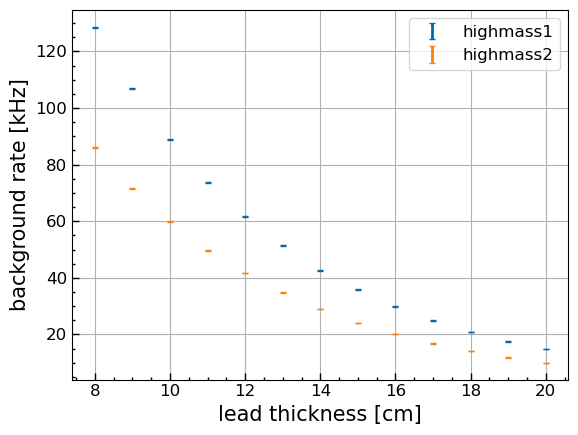

In [13]:
def plot_rate_w_cutoff(Emin_approx = 0, void = True):
    # background rates for pileup considerations
    imin = np.where(Ebins > Emin_approx)[0][0]
    Emin = Ebins[imin]
    lead = []
    rate = []
    drate = []
    rate2 = []
    drate2 = []

    for meas in df.keys():
        lead.append(meas[0])
        spec = df[meas]['highmass1_all'].values
        spec2 = df[meas]['highmass2_all'].values

        ct = spec[imin:].sum()
        ct2 = spec2[imin:].sum()
        T = leadrates.meas_exposures[meas]

        rate.append(ct/T/1e3)
        drate.append(np.sqrt(ct)/T/1e3)


        rate2.append(ct2/T/1e3)
        drate2.append(np.sqrt(ct2)/T/1e3)


    plt.figure()
    plt.errorbar(lead, rate, yerr = drate, linestyle = '', marker = '', capsize = 2, label = 'highmass1')
    plt.errorbar(lead, rate2, yerr = drate2, linestyle = '', marker = '', capsize = 2, label = 'highmass2')
    plt.grid()
    #plt.semilogy()
    #plt.title('background rate vs lead thickness')
    #if imin == 0:
    #    plt.title(f'lead + 1 cm poly (>100 eV)')
    #else:
    #    plt.title(f'lead + 1 cm poly (>{Emin:.2g} MeV)')
    plt.xlabel('lead thickness [cm]')
    plt.ylabel('background rate [kHz]')
    plt.legend()

    if not void:
        return rate

rate = plot_rate_w_cutoff(void = False)
min(rate)

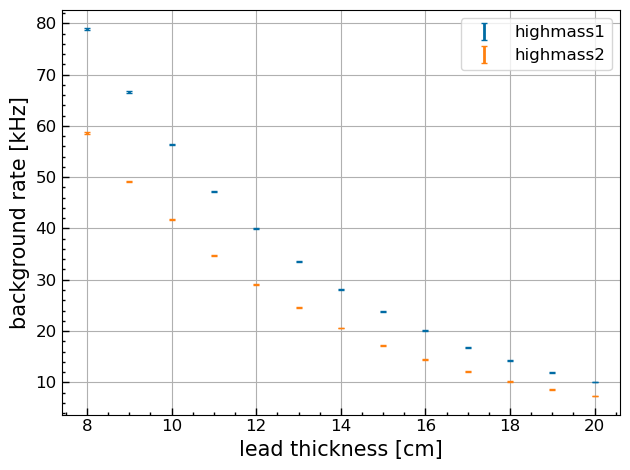

In [17]:
rates = plot_rate_w_cutoff(0.1, void = False)
min(rates), 'kHz'
plt.tight_layout()
plt.savefig('../figures/sim_tuning_lead.pdf')

In [15]:
[r/rs for r, rs in zip(rate,rates)]

[1.451761638875071,
 1.4884489903888543,
 1.5620842832632147,
 1.5013810011482482,
 1.6048280882704353,
 1.5160561604433997,
 1.5469081476677937,
 1.5303058652607944,
 1.4918247824560753,
 1.6297453948140326,
 1.4648136581303353,
 1.4664431613584155,
 1.5801581359916992]

In [16]:
meas = (20.,1.)
leadrates.totals[meas][2,1]/leadrates.meas_exposures[meas], leadrates.rates[meas][2,1]

AttributeError: 'BackgroundRates' object has no attribute 'totals'